In [1]:
%load_ext autoreload
%autoreload complete

import function_sleepWakeLabels as sleep
import graphRegularizedSVD_sleepWakeMatrices as gsvd
from save_gsvds import save_gsvds
import pandas as pd
import numpy as np
from scipy.stats import pearsonr
import glob
import re
from os.path import join
from pathlib import Path
from datetime import date, datetime
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns
from dotenv import dotenv_values
import itertools
import pickle
from tqdm.notebook import tqdm
import pyarrow.parquet as pq
from scipy.sparse import csgraph
import scipy.linalg

sns.set_theme(style="darkgrid")

cfg = dotenv_values()

dat_dir = cfg['DAT_DIR']

/Users/loranknol/Documents/Code/graph-svd/graphRegularizedSVD_sleepWakeMatrices.py:29: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [ ]:
gsvd_file = 'gsvd_results.pkl'

with open(join(dat_dir, gsvd_file), 'rb') as handle:
    gsvd_results = pickle.load(handle)

In [7]:
gsvd_results['3009']

{'dates':               date  dayNumber
 1       2021-01-13        1.0
 493     2021-01-14        2.0
 2015    2021-01-15        3.0
 2812    2021-01-16        4.0
 3398    2021-01-17        5.0
 ...            ...        ...
 220403  2021-07-09      178.0
 220609  2021-07-10      179.0
 221457  2021-07-11      180.0
 222164  2021-07-12      181.0
 223087  2021-07-13      182.0
 
 [182 rows x 2 columns],
 'Mactivity': hour          0      1     2      3     4    5    6     7     8    9   ...  \
 dayNumber                                                              ...   
 2.0          0.0    0.0   0.0   26.0   0.0  0.0  0.0   0.0   3.0  0.0  ...   
 3.0         98.0    0.0   0.0    4.0   0.0  0.0  0.0   0.0   0.0  0.0  ...   
 4.0          0.0   21.0  80.0    0.0   0.0  0.0  0.0   0.0   0.0  0.0  ...   
 5.0         28.0    0.0  78.0    9.0   0.0  0.0  0.0   0.0   0.0  0.0  ...   
 6.0          0.0    0.0   0.0    0.0  73.0  0.0  0.0   0.0   0.0  0.0  ...   
 ...          ...    ...  

# Concatenate all raw key press files

In [ ]:
all_files = sorted(glob.glob("sub-*/preproc/*dat-kp.csv", root_dir=dat_dir, recursive=True))

pat = re.compile(r"sub-(\d+)")
subs = [re.match(pat, f).group(1) for f in all_files]

In [7]:
dats_kp = []

for f, sub in tqdm(zip(all_files, subs), total=len(subs)):
    dat_kp = pd.read_csv(join(dat_dir, f), index_col=0)

    dat_kp['subject'] = sub

    dats_kp.append(dat_kp)

  0%|          | 0/73 [00:00<?, ?it/s]

In [8]:
dat_kp = pd.concat(dats_kp)

dat_kp

,healthCode,recordId,createdOnTimestamp,createdOnTimeZone,appVersion,phoneInfo,sessionDuration,timestamp,keypress_type,keypress_duration,distanceFromCenter,distanceFromPrevious,sessionNumber,sessionTimestampLocal,keypressTimestampLocal,phoneType,IKD,previousKeyType,handedness,subject
1,xcRXm_CyRS4Z5yIk4a3c1jy8,082lh76S4AAaxVPrhO9OCRg0,1607539730980,-600,"version 2.2.0, build 30",iPhone 7+; iOS/14.2,11.057200,1.607540e+09,backspace,0.066559,0.373474,NaN,1,2020-12-09 12:48:50,2020-12-09 12:48:50,iPhone 7 Plus,NaN,NaN,two-handed,3004
2,xcRXm_CyRS4Z5yIk4a3c1jy8,082lh76S4AAaxVPrhO9OCRg0,1607539730980,-600,"version 2.2.0, build 30",iPhone 7+; iOS/14.2,11.057200,1.607540e+09,backspace,0.081666,0.282457,0.101347,1,2020-12-09 12:48:50,2020-12-09 12:48:51,iPhone 7 Plus,0.180994,backspace,two-handed,3004
3,xcRXm_CyRS4Z5yIk4a3c1jy8,082lh76S4AAaxVPrhO9OCRg0,1607539730980,-600,"version 2.2.0, build 30",iPhone 7+; iOS/14.2,11.057200,1.607540e+09,backspace,0.065177,0.326716,0.086154,1,2020-12-09 12:48:50,2020-12-09 12:48:51,iPhone 7 Plus,0.167516,backspace,two-handed,3004
4,xcRXm_CyRS4Z5yIk4a3c1jy8,082lh76S4AAaxVPrhO9OCRg0,1607539730980,-600,"version 2.2.0, build 30",iPhone 7+; iOS/14.2,11.057200,1.607540e+09,backspace,0.066714,0.194460,0.132261,1,2020-12-09 12:48:50,2020-12-09 12:48:51,iPhone 7 Plus,0.634153,backspace,two-handed,3004
5,xcRXm_CyRS4Z5yIk4a3c1jy8,082lh76S4AAaxVPrhO9OCRg0,1607539730980,-600,"version 2.2.0, build 30",iPhone 7+; iOS/14.2,11.057200,1.607540e+09,alphanum,0.065304,0.140284,5.093239,1,2020-12-09 12:48:50,2020-12-09 12:48:52,iPhone 7 Plus,0.415984,backspace,two-handed,3004
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4796,QPcKJhuJ0zubv6YZPvRAJkTt,OCs7cwhTYOl2ykBRL6JlatA1,1629784463187,-500,"version 2.2.0, build 30",iPhone XR; iOS/14.7.1,9.509615,1.629784e+09,backspace,0.083075,0.284813,0.047393,61,2021-08-24 00:54:23,2021-08-24 00:54:25,iPhone XR,0.175367,backspace,two-handed,3999
4797,QPcKJhuJ0zubv6YZPvRAJkTt,OCs7cwhTYOl2ykBRL6JlatA1,1629784463187,-500,"version 2.2.0, build 30",iPhone XR; iOS/14.7.1,9.509615,1.629784e+09,alphanum,0.074935,0.098554,1.752288,61,2021-08-24 00:54:23,2021-08-24 00:54:26,iPhone XR,0.598603,backspace,two-handed,3999
4798,QPcKJhuJ0zubv6YZPvRAJkTt,OCs7cwhTYOl2ykBRL6JlatA1,1629784463187,-500,"version 2.2.0, build 30",iPhone XR; iOS/14.7.1,9.509615,1.629784e+09,alphanum,0.057926,0.088836,0.128971,61,2021-08-24 00:54:23,2021-08-24 00:54:26,iPhone XR,0.150312,alphanum,two-handed,3999
4799,QPcKJhuJ0zubv6YZPvRAJkTt,OCs7cwhTYOl2ykBRL6JlatA1,1629784463187,-500,"version 2.2.0, build 30",iPhone XR; iOS/14.7.1,9.509615,1.629784e+09,alphanum,0.090652,0.132683,4.508717,61,2021-08-24 00:54:23,2021-08-24 00:54:26,iPhone XR,0.126315,alphanum,two-handed,3999


In [9]:
dat_kp.to_parquet(join(dat_dir, 'dat_kp.parquet'))

# Data to matrices

In [37]:
dat_kp: pd.DataFrame = pq.read_table(join(dat_dir, 'dat_kp.parquet')).to_pandas()

OSError: Corrupt snappy compressed data.

In [36]:
dat_kp: pd.DataFrame = pd.read_pickle(join(dat_dir, 'dat_kp.gz'))

KeyboardInterrupt: 

In [42]:
dat_kp

,healthCode,recordId,createdOnTimestamp,createdOnTimeZone,appVersion,phoneInfo,sessionDuration,timestamp,keypress_type,keypress_duration,distanceFromCenter,distanceFromPrevious,sessionNumber,sessionTimestampLocal,keypressTimestampLocal,phoneType,IKD,previousKeyType,handedness,subject
1,xcRXm_CyRS4Z5yIk4a3c1jy8,082lh76S4AAaxVPrhO9OCRg0,1607539730980,-600,"version 2.2.0, build 30",iPhone 7+; iOS/14.2,11.057200,1.607540e+09,backspace,0.066559,0.373474,NaN,1,2020-12-09 12:48:50,2020-12-09 12:48:50,iPhone 7 Plus,NaN,None,two-handed,3004
2,xcRXm_CyRS4Z5yIk4a3c1jy8,082lh76S4AAaxVPrhO9OCRg0,1607539730980,-600,"version 2.2.0, build 30",iPhone 7+; iOS/14.2,11.057200,1.607540e+09,backspace,0.081666,0.282457,0.101347,1,2020-12-09 12:48:50,2020-12-09 12:48:51,iPhone 7 Plus,0.180994,backspace,two-handed,3004
3,xcRXm_CyRS4Z5yIk4a3c1jy8,082lh76S4AAaxVPrhO9OCRg0,1607539730980,-600,"version 2.2.0, build 30",iPhone 7+; iOS/14.2,11.057200,1.607540e+09,backspace,0.065177,0.326716,0.086154,1,2020-12-09 12:48:50,2020-12-09 12:48:51,iPhone 7 Plus,0.167516,backspace,two-handed,3004
4,xcRXm_CyRS4Z5yIk4a3c1jy8,082lh76S4AAaxVPrhO9OCRg0,1607539730980,-600,"version 2.2.0, build 30",iPhone 7+; iOS/14.2,11.057200,1.607540e+09,backspace,0.066714,0.194460,0.132261,1,2020-12-09 12:48:50,2020-12-09 12:48:51,iPhone 7 Plus,0.634153,backspace,two-handed,3004
5,xcRXm_CyRS4Z5yIk4a3c1jy8,082lh76S4AAaxVPrhO9OCRg0,1607539730980,-600,"version 2.2.0, build 30",iPhone 7+; iOS/14.2,11.057200,1.607540e+09,alphanum,0.065304,0.140284,5.093239,1,2020-12-09 12:48:50,2020-12-09 12:48:52,iPhone 7 Plus,0.415984,backspace,two-handed,3004
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4796,QPcKJhuJ0zubv6YZPvRAJkTt,OCs7cwhTYOl2ykBRL6JlatA1,1629784463187,-500,"version 2.2.0, build 30",iPhone XR; iOS/14.7.1,9.509615,1.629784e+09,backspace,0.083075,0.284813,0.047393,61,2021-08-24 00:54:23,2021-08-24 00:54:25,iPhone XR,0.175367,backspace,two-handed,3999
4797,QPcKJhuJ0zubv6YZPvRAJkTt,OCs7cwhTYOl2ykBRL6JlatA1,1629784463187,-500,"version 2.2.0, build 30",iPhone XR; iOS/14.7.1,9.509615,1.629784e+09,alphanum,0.074935,0.098554,1.752288,61,2021-08-24 00:54:23,2021-08-24 00:54:26,iPhone XR,0.598603,backspace,two-handed,3999
4798,QPcKJhuJ0zubv6YZPvRAJkTt,OCs7cwhTYOl2ykBRL6JlatA1,1629784463187,-500,"version 2.2.0, build 30",iPhone XR; iOS/14.7.1,9.509615,1.629784e+09,alphanum,0.057926,0.088836,0.128971,61,2021-08-24 00:54:23,2021-08-24 00:54:26,iPhone XR,0.150312,alphanum,two-handed,3999
4799,QPcKJhuJ0zubv6YZPvRAJkTt,OCs7cwhTYOl2ykBRL6JlatA1,1629784463187,-500,"version 2.2.0, build 30",iPhone XR; iOS/14.7.1,9.509615,1.629784e+09,alphanum,0.090652,0.132683,4.508717,61,2021-08-24 00:54:23,2021-08-24 00:54:26,iPhone XR,0.126315,alphanum,two-handed,3999


In [10]:
dat_kp['keypressTimestampLocal'] = pd.to_datetime(dat_kp['keypressTimestampLocal'])

dat_kp['date'] = dat_kp['keypressTimestampLocal'].dt.date
dat_kp['hour'] = dat_kp['keypressTimestampLocal'].dt.hour

In [42]:
subs = np.sort(dat_kp['subject'].unique())

typing_matrices = {}

for sub in tqdm(subs):
    # Make sure dat_kp_sub is a copy and not a view into dat_kp
    dat_kp_sub = dat_kp.loc[dat_kp['subject'] == sub].copy()

    n_presses_mat, speed_mat = gsvd.get_typingMatrices(dat_kp_sub)
    typing_matrices[sub] = {
        'n_presses_mat': n_presses_mat,
        'speed_mat': speed_mat
    }

  0%|          | 0/73 [00:00<?, ?it/s]

KeyboardInterrupt: 

## Accelerometer measures

In [13]:
dat_ses: pd.DataFrame = pq.read_table(join(dat_dir, 'dat_ses.parquet')).to_pandas()

dat_ses['hour'] = dat_ses['hour'].astype(int)

dat_ses

,subject,sessionNumber,medianIKD,percent95IKD,madIKD,handedness,autocorrectRate,backspaceRate,sessionTimestampLocal,totalKeyPresses,active,upright,bed,hour,date
0,3004,1,0.330445,1.733809,0.209613,two-handed,0.000000,0.363636,2020-12-09 12:48:50+00:00,11,False,True,False,12,2020-12-09
1,3004,2,0.241563,0.280718,0.036925,one-handed,0.000000,0.000000,2020-12-09 12:58:28+00:00,5,False,False,True,12,2020-12-09
2,3004,3,0.190657,0.368669,0.090528,two-handed,0.044118,0.073529,2020-12-09 13:00:00+00:00,68,False,False,True,13,2020-12-09
3,3004,4,0.225473,0.335222,0.038922,one-handed,0.000000,0.000000,2020-12-09 13:28:31+00:00,9,True,False,False,13,2020-12-09
4,3004,5,0.171984,0.295214,0.099876,two-handed,0.000000,0.000000,2020-12-09 13:31:20+00:00,11,True,False,False,13,2020-12-09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
351595,3104,471,0.149802,0.621498,0.072132,two-handed,0.048276,0.200000,2022-10-24 20:06:02+00:00,145,False,True,False,20,2022-10-24
351596,3104,472,0.245353,1.576711,0.154588,one-handed,0.000000,0.000000,2022-10-24 20:09:29+00:00,7,False,True,False,20,2022-10-24
351597,3104,473,0.173862,0.279628,0.128312,two-handed,0.000000,0.000000,2022-10-24 20:10:07+00:00,5,False,True,False,20,2022-10-24
351598,3104,474,0.150020,0.573413,0.074216,two-handed,0.037182,0.225049,2022-10-24 20:28:27+00:00,511,False,True,False,20,2022-10-24


In [113]:
typing_matrices, dates = gsvd.get_typing_matrices(dat_kp, dat_ses)

In [91]:
sub = '3009'

n_presses_df: pd.DataFrame = typing_matrices[sub]['n_presses']
ikd_df: pd.DataFrame = typing_matrices[sub]['IKD']

n_presses_mat = n_presses_df.to_numpy()
ikd_mat = ikd_df.to_numpy()

In [92]:
n_presses_df

hour,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
dayNumber,,,,,,,,,,,,,,,,,,,,,
13,69,137,0,0,0,0,0,0,50,33,...,0,20,0,0,202,51,0,80,0,0
14,50,37,0,0,0,0,0,0,0,0,...,0,0,0,0,14,70,73,0,85,0
15,134,32,0,0,0,0,0,0,13,61,...,298,90,0,0,0,22,24,65,6,74
23,0,66,207,0,0,0,0,34,2,0,...,252,83,191,0,6,30,69,0,0,4
24,328,28,25,0,0,0,0,0,0,9,...,21,0,74,48,36,59,0,0,0,27
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
176,0,30,39,146,0,0,0,47,0,0,...,0,0,0,0,0,0,7,0,82,0
177,5,0,0,0,0,0,0,0,21,0,...,81,18,54,0,0,0,0,0,27,0
178,0,0,0,0,0,0,0,0,0,0,...,155,0,0,35,0,0,208,0,0,180


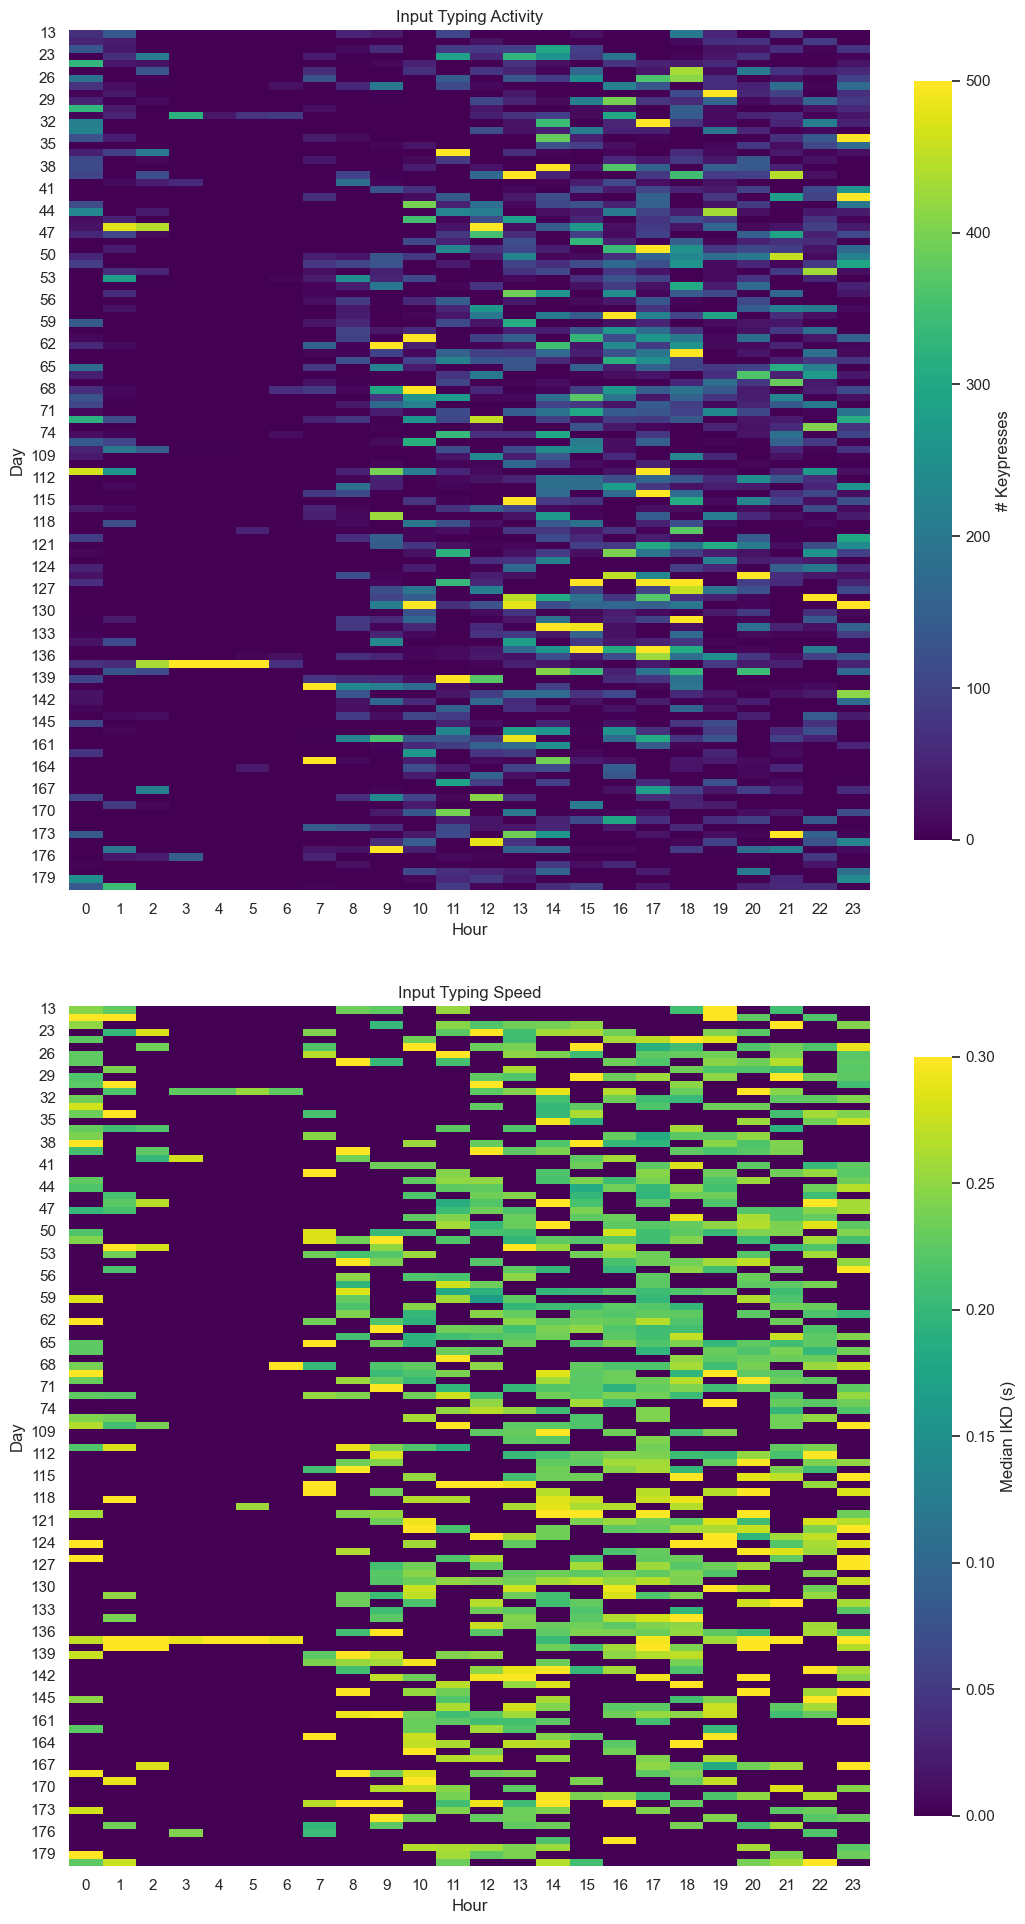

In [93]:
_ = gsvd.plot_input_heatmaps(n_presses_df, ikd_df)

## Filtering

1. Get average rate of non-zero hours per day
2. Get median number of median number of key presses per day
3. Exclude subjects based on these numbers
4. Exclude first and last days
5. Exclude subjects with less than seven remaining days (i.e., <9 total)
6. Calculate the same metrics as in 1. and 2. but in a 7-day sliding window, marking all days in a window for removal if they don't make the cut (use pandas' rolling method)

In [14]:
group_by = ['subject', 'dayNumber', 'hour']



kp_variables = ['IKD', 'n_presses']

dat_kp_ranked = gsvd.rank_dates(dat_kp)
dates = dat_kp_ranked[['subject', 'date', 'dayNumber']].drop_duplicates()

# Number of key presses, including backspace and autocorrect
dat_kp_n_presses = dat_kp_ranked.groupby(group_by).size()
dat_kp_n_presses.name = 'n_presses'

# _calculate_aaikd filters out some hours, so joining with dat_kp_n_presses will result in NaNs
dat_kp_vars = gsvd._calculate_aaikd(dat_kp_ranked, group_by)
dat_kp_vars = dat_kp_vars.join(dat_kp_n_presses, how='outer').fillna(0)

dat_kp_masked, participant_mask = gsvd._pre_filter(dat_kp_vars)


ses_variables = ['active', 'upright']

dat_ses_ranked = gsvd.rank_dates(dat_ses)

dat_ses_ranked_g = dat_ses_ranked.groupby(by=group_by)

# Some accelerometer measurements are NaNs
dat_ses_vars = dat_ses_ranked_g[ses_variables].mean().fillna(0)

dat_ses_masked, _ = gsvd._pre_filter(dat_ses_vars, participant_mask)


dat_masked = dat_kp_masked.join(dat_ses_masked, how='outer').fillna(0)
dats_dict = gsvd.pivot_split(dat_masked, kp_variables + ses_variables)

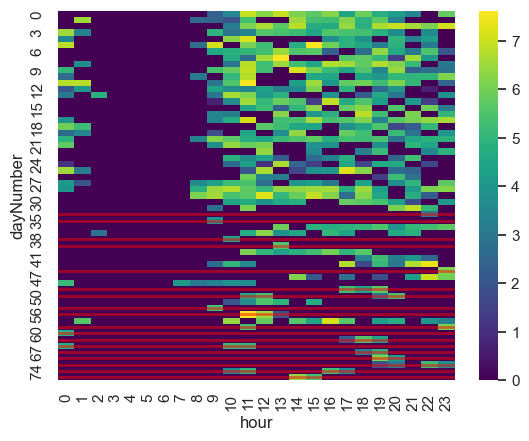

In [62]:
n_presses_df = dats_dict['3100']['n_presses']

n_presses_binary = n_presses_df > 0
n_presses_nan = n_presses_df.where(n_presses_df > 0)

perc_hours_active = n_presses_binary.mean(axis=1)
median_n_presses = n_presses_nan.median(axis=1)

day_mask: pd.Series = perc_hours_active >= 0.2

# dayNumber index is turned into a column
day_mask_df = day_mask.reset_index(name='included')

sns.heatmap(np.log1p(n_presses_df), cmap='viridis')

for excluded in day_mask_df.loc[~day_mask_df['included']].index.values:
    sns.lineplot(x=np.arange(0, 25), y=[excluded+0.5]*25, color='red', alpha=0.5, linewidth=2)

# sns.lineplot(x=np.arange(0, 25), y=[58+0.5]*25, color='red', alpha=0.5)

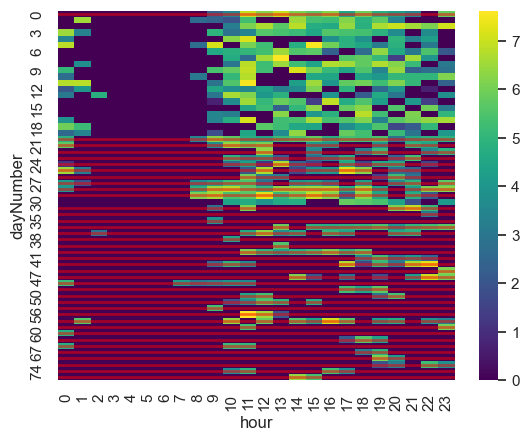

In [64]:
excluded2 = gsvd._get_days_to_remove(n_presses_df)

sns.heatmap(np.log1p(n_presses_df), cmap='viridis')

for exc in excluded2:
    sns.lineplot(x=np.arange(0, 25), y=[exc+0.5]*25, color='red', alpha=0.5, linewidth=2)

In [47]:
day_mask.reset_index()

,dayNumber,0
0,0,True
1,1,True
2,2,True
3,3,True
4,4,True
5,5,True
6,6,True
7,7,True
8,8,True
9,9,True


In [37]:
# Gonna skip the rolling exclusion for now, will just use Mindy's method

rolling = dat_kp_vars_complete.groupby('subject').rolling(window=7)



IKD  n_presses
subject dayNumber hour                     
3004    0         0          NaN        NaN
                  1          NaN        NaN
                  2          NaN        NaN
                  3          NaN        NaN
                  4          NaN        NaN
...                          ...        ...
3999    0         19    0.822115     4474.0
                  20    0.822115     4474.0
                  21    0.639416     4397.0
                  22    0.486903     3481.0
                  23    0.486903     3481.0

[133368 rows x 2 columns]

In [112]:
def plot_mat(mat: pd.DataFrame):
    f, ax = plt.subplots(nrows=1,ncols=1,figsize=(11,10), facecolor='w')

    sns.heatmap(mat, cmap='Spectral',
                cbar_kws={'fraction': 0.043})
    plt.xticks(rotation=0)
    plt.yticks(rotation=0)
    ax.set(title='Epic title here', xlabel='Hour', ylabel='Day')    
    f.tight_layout()

## Save to / load from file

In [114]:
typing_mat_dict = {
    "typing_matrices": typing_matrices,
    "dates": dates
}

with open(join(dat_dir, 'typing_mat_dict.pkl'), 'wb') as f:
    pickle.dump(typing_mat_dict, f)

In [2]:
with open(join(dat_dir, 'typing_mat_dict.pkl'), 'rb') as f:
    typing_mat_dict = pickle.load(f)

typing_matrices: dict[str, dict[str, pd.DataFrame]] = typing_mat_dict["typing_matrices"]
dates: pd.DataFrame = typing_mat_dict["dates"]

# Train and test GSVD

In [9]:
from sklearn.preprocessing import normalize

participant = '3009'

dfs = typing_matrices[participant]
modalities = list(dfs.keys())

# Subset the DataFrames to use, flatten
dfs_svd = {modality: dfs[modality] for modality in modalities}
dats_svd = {modality: df.to_numpy().flatten() for modality, df in dfs_svd.items()}

# Transform to constrain range
if 'n_presses' in dats_svd:
    dats_svd['n_presses'] = np.log1p(dats_svd['n_presses'])

# W is constructed by looking at the index values, 
# so actual matrix values are irrelevant; just use the first one
W_binary = gsvd.construct_w_binary(dfs_svd[modalities[0]])

dat_svd = np.vstack(list(dats_svd.values()))

# Make train/test split
train_ratio = 0.1

split_idx = 24 * int(dat_svd.shape[1] / 24 * train_ratio)
dat_svd_train = dat_svd[:, :split_idx]
dat_svd_test = dat_svd[:, split_idx:]

dat_svd_train = normalize(dat_svd_train.T).T
dat_svd_test = normalize(dat_svd_test.T).T

Text(0.5, 1.0, 'log(1 + #keypresses), participant 3009')

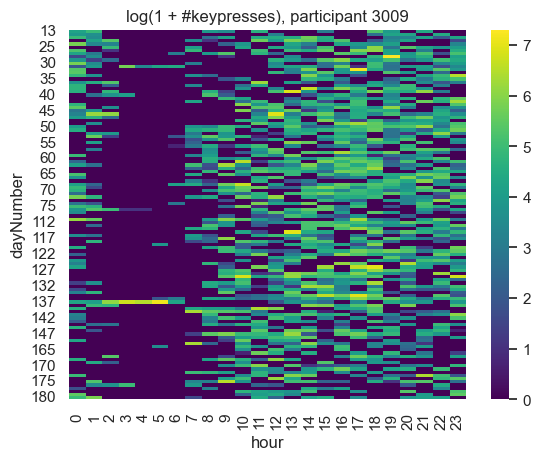

In [8]:
sns.heatmap(np.log1p(dfs_svd['n_presses']), cmap='viridis')
plt.title(f"log(1 + #keypresses), participant {participant}")

In [22]:
# Calculate SVD
lapl = csgraph.laplacian(W_binary[:split_idx, :split_idx])
rank = 1
alpha = 1

# Get graph-regularised SVD
U_tilde, W_hat = gsvd.regularized_svd_chol(dat_svd_train, lapl, rank, alpha)

if W_hat.max() <= 0.00000001:
    W_hat = W_hat * -1

In [40]:
_, W_star_old = gsvd.regularized_svd_chol_old(dat_svd_train, lapl, rank, alpha)

if W_star_old.max() <= 0.00000001:
    W_star_old = W_star_old * -1

np.allclose(W_hat, W_star_old)

True

In [7]:
I = np.eye(lapl.shape[0])
C = I + (alpha * lapl)
L = scipy.linalg.cholesky(C, lower=True)

# XL^T^-1
Y = scipy.linalg.solve_triangular(L, dat_svd_train.T, lower=True).T

U, sigma, Vh = scipy.linalg.svd(Y)

# Sigma might be rectangular, in which case np.diag will not work
Sigma = np.zeros((U.shape[1], Vh.shape[0]))
np.fill_diagonal(Sigma, sigma)

Sigma_Vh = Sigma @ Vh
Sigma_Vh_tilde = Sigma[:rank, :rank] @ Vh[:rank, :]

U_tilde_tmp = U[:, :rank]

np.allclose(U_tilde_tmp.T @ Y, Sigma_Vh_tilde)

True

In [10]:
sigma

array([17.31156378,  1.37084317,  1.06312889,  0.25345438])

Eigenspectrum is clearly dominated by the first eigenvalue, which might be why I don't see a difference between the Vidar et al. and the Donelli implementations.

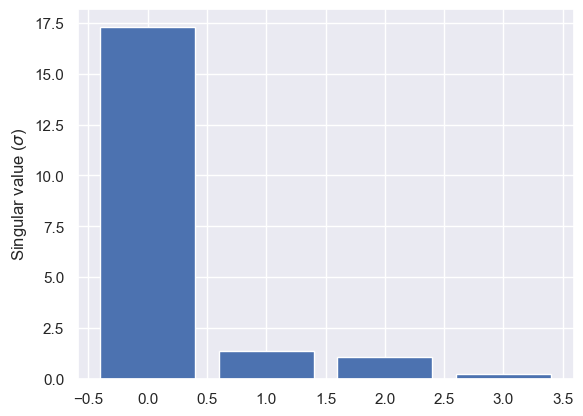

In [14]:
plt.bar(np.arange(len(sigma)), sigma)
plt.ylabel("Singular value ($\\sigma$)")

plt.show()

In [23]:
# Calculate SVD for test cases
lapl = csgraph.laplacian(W_binary[split_idx:, split_idx:])

W_hat_test = gsvd.regularized_svd_test(
    dat_svd_test, 
    lapl, 
    alpha, 
    U_tilde
)

if W_hat_test.max() <= 0.00000001:
    W_hat_test = W_hat_test * -1

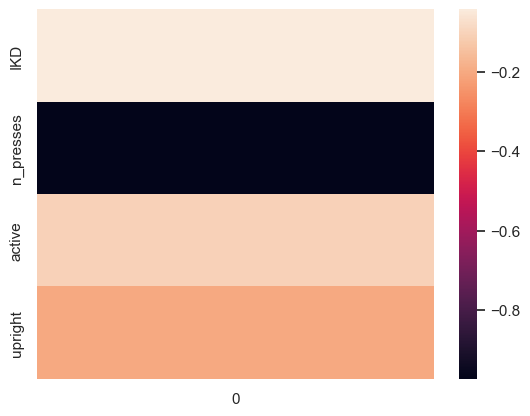

In [24]:
sns.heatmap(U_tilde)
plt.yticks(np.arange(U_tilde.shape[0]) + 0.5, modalities)

plt.show()

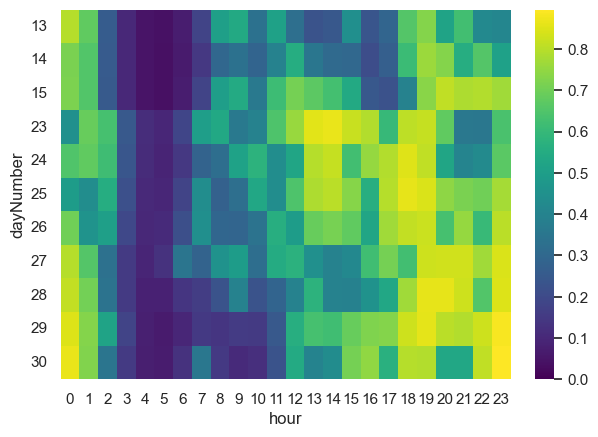

In [25]:
plt.close()

svd_mat_train = W_hat.reshape((-1, 24))

ikd_index = dfs['IKD'].index
ikd_columns = dfs['IKD'].columns
split_idx_day = split_idx // 24

svd_train_df = pd.DataFrame(svd_mat_train, 
                            index=ikd_index[:split_idx_day], 
                            columns=ikd_columns)

sns.heatmap(svd_train_df, cmap='viridis', vmin=0,#vmax=0.25,
            cbar_kws={'fraction': 0.043})
plt.xticks(rotation=0)
plt.yticks(rotation=0)
# a.set(title=f"Graph-regularised SVD participant {participant}", xlabel='Hour', ylabel='Day')    

plt.show()

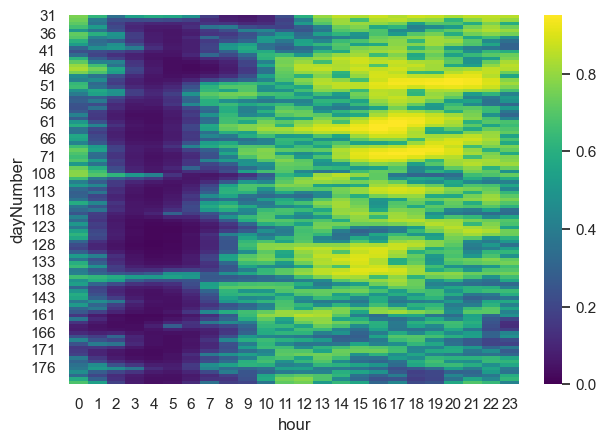

In [26]:
plt.close()

svd_mat_test = W_hat_test.reshape((-1, 24))

svd_test_df = pd.DataFrame(svd_mat_test, 
                           index=ikd_index[split_idx_day:], 
                           columns=ikd_columns)

sns.heatmap(svd_test_df, cmap='viridis', vmin=0,#vmax=0.25,
            cbar_kws={'fraction': 0.043})
plt.xticks(rotation=0)
plt.yticks(rotation=0)
# a.set(title=f"Graph-regularised SVD participant {participant}", xlabel='Hour', ylabel='Day')    

plt.show()

Text(47.25, 0.5, 'Day')

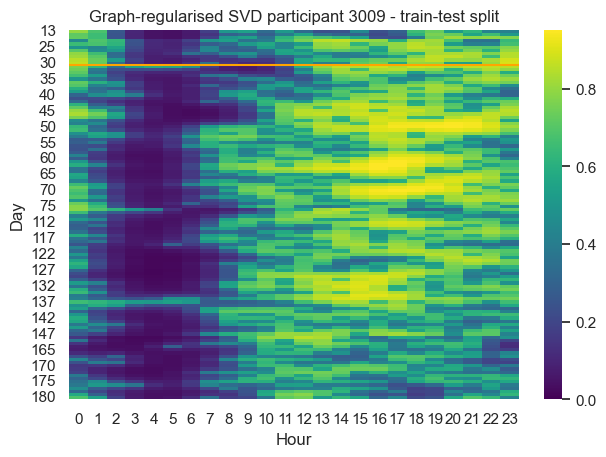

In [27]:
plt.close()

# Stitch them together
svd_mat = np.vstack((svd_mat_train, svd_mat_test))
svd_df = pd.DataFrame(svd_mat,
                      index=dfs['IKD'].index, 
                      columns=dfs['IKD'].columns)

sns.heatmap(svd_df, cmap='viridis', vmin=0,#vmax=0.25,
            cbar_kws={'fraction': 0.043})
sns.lineplot(x=np.arange(0, 25), y=[split_idx/24]*25, color='orange')
plt.xticks(rotation=0)
plt.yticks(rotation=0)
plt.title(f"Graph-regularised SVD participant {participant} - train-test split")
plt.xlabel("Hour")
plt.ylabel("Day")

# plt.savefig(join('images', f'train_test_{participant}_line.pdf'))

# Get graph-regularized SVD

## Compare full to train-test

In [28]:
svd_mats, _ = gsvd.calculate_svd(typing_matrices, alpha=alpha, train_ratio=1)

  0%|          | 0/47 [00:00<?, ?it/s]

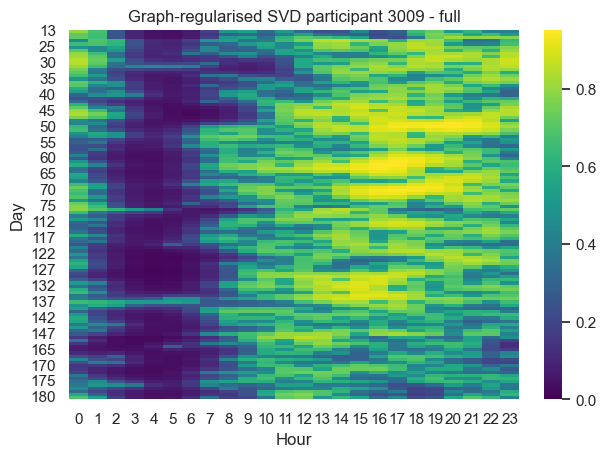

In [34]:
participant = '3009'

svd_full_df = pd.DataFrame(svd_mats[participant], 
                           index=ikd_index, 
                           columns=ikd_columns)

sns.heatmap(svd_full_df, cmap='viridis', vmin=0,#vmax=0.25,
            cbar_kws={'fraction': 0.043})
plt.xticks(rotation=0)
plt.yticks(rotation=0)
plt.title(f"Graph-regularised SVD participant {participant} - full")
plt.xlabel("Hour")
plt.ylabel("Day")

plt.savefig(join('images', f'full_gsvd_{participant}_line.pdf'))

<Axes: xlabel='hour', ylabel='dayNumber'>

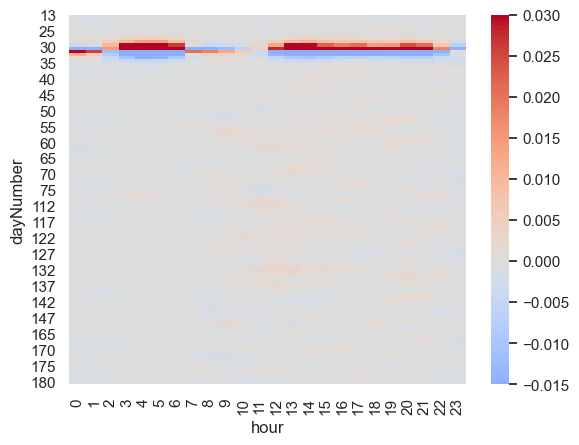

In [35]:
diff_df = pd.DataFrame(svd_mats[participant] - svd_mat,
                       index=svd_df.index,
                       columns=svd_df.columns)

sns.heatmap(diff_df, cmap='coolwarm', center=0, vmin=-0.015, vmax=0.03)

## Train-test for all participants

In [3]:
alpha = 1

svd_mats, split_indices = gsvd.calculate_svd(
    typing_matrices, alpha=alpha, train_ratio=0.1)

  0%|          | 0/47 [00:00<?, ?it/s]

/Users/loranknol/Documents/Code/graph-svd/graphRegularizedSVD_sleepWakeMatrices.py:771: UserWarning: No data in training set for participant 3023
  warnings.warn(f"No data in training set for participant {subject}")
/Users/loranknol/Documents/Code/graph-svd/graphRegularizedSVD_sleepWakeMatrices.py:771: UserWarning: No data in training set for participant 3034
  warnings.warn(f"No data in training set for participant {subject}")


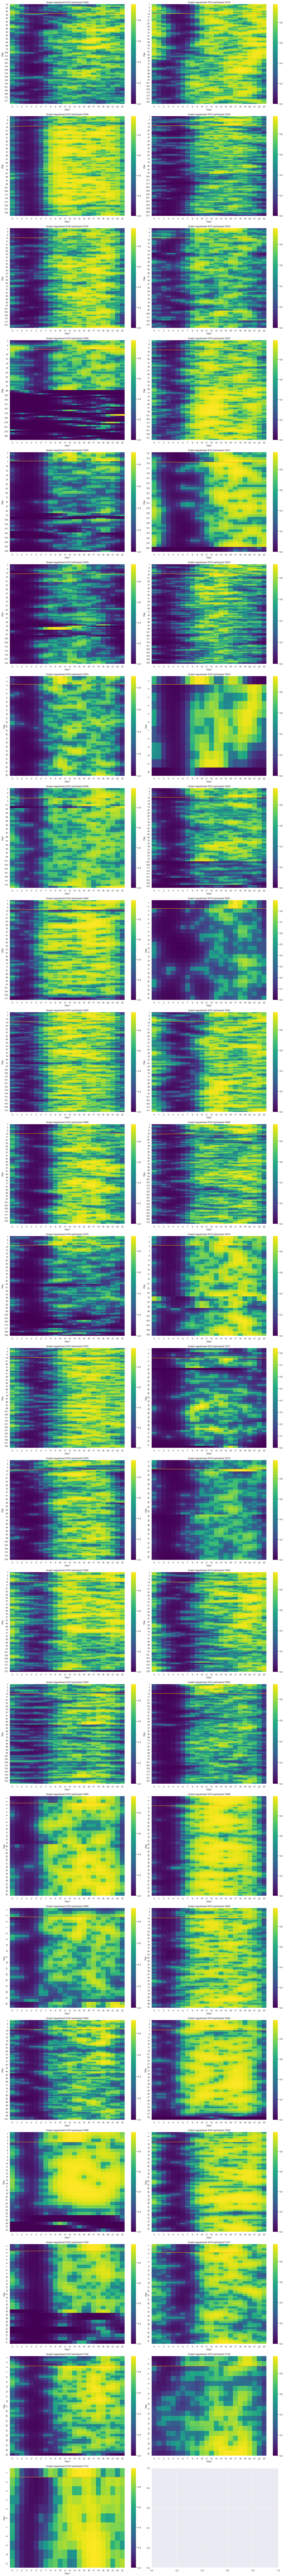

In [5]:
def plot_svds(svd_mats: dict[str, np.ndarray], typing_matrices: dict[str, dict[str, pd.DataFrame]]):
    n_participants = len(svd_mats)

    ncol = 2
    nrow = n_participants // ncol + (n_participants % ncol != 0)

    f, ax = plt.subplots(nrows=nrow,ncols=ncol,figsize=(20,180), facecolor='w')

    for i, participant in enumerate(svd_mats):
        row = i // ncol
        col = i % ncol
        a = ax[row, col]

        ikd_df = typing_matrices[participant]['IKD']

        split_idx = None
        svd_mat = svd_mats[participant]
        if 'train' in svd_mat:
            # At which day to draw the split line
            split_idx = svd_mat['train'].shape[0]
            
            svd_mat = np.vstack((
                svd_mat['train'],
                svd_mat['test']
            ))
        
        svd_mat_df = pd.DataFrame(svd_mat, 
                                  index=ikd_df.index, 
                                  columns=ikd_df.columns)


        sns.heatmap(svd_mat_df, cmap='viridis', vmin=0,#vmax=0.25,
                    cbar_kws={'fraction': 0.043}, ax=a)
        
        if split_idx is not None:
            sns.lineplot(x=np.arange(0, 25), y=[split_idx]*25, color='orange', ax=a)

        plt.xticks(rotation=0)
        plt.yticks(rotation=0)
        a.set(title=f"Graph-regularised SVD participant {participant}", xlabel='Hour', ylabel='Day')    
    
    f.tight_layout()

    f.savefig('images/svds_train_test_10_90.pdf')

plot_svds(svd_mats, typing_matrices)

In [9]:
def plot_mats(
        svd_mats: dict[str, np.ndarray], 
        typing_matrices: dict[str, dict[str, pd.DataFrame]], 
        participant: str,
        save: bool = False
    ):

    part_mats = typing_matrices[participant]
    
    n_presses_df = part_mats['n_presses']
    ikd_df = part_mats['IKD']
    active_df = part_mats['active']
    upright_df = part_mats['upright']

    split_idx = None
    svd_mat = svd_mats[participant]
    if 'train' in svd_mat:
        # At which day to draw the split line
        split_idx = svd_mat['train'].shape[0]
        
        svd_mat = np.vstack((
            svd_mat['train'],
            svd_mat['test']
        ))
        
    svd_mat_df = pd.DataFrame(svd_mat, 
                              index=ikd_df.index, 
                              columns=ikd_df.columns)

    plt.rcParams.update({'font.size': 64})
    # Visualize heatmap of steps
    fig, ax = plt.subplots(nrows=3,ncols=2, sharex=False, sharey=False,
                           figsize=(20,25), facecolor='w')

    # PLOT 1
    a = ax[0, 0]
    sns.heatmap(np.log1p(n_presses_df), cmap='viridis', ax=a, vmin=0, #vmax=500,
                cbar_kws={'label': 'log(1 + #Keypresses)', 'fraction': 0.043})
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    a.set(title='Input typing activity', xlabel='Hour', ylabel='Day')

    # PLOT 2
    a = ax[0, 1]
    sns.heatmap(ikd_df, cmap='viridis', ax=a, vmin=0, #vmax=0.3,
                cbar_kws={'label': 'Median IKD (s)', 'fraction': 0.043})
    plt.xticks(rotation=0)
    plt.yticks(rotation=0)
    a.set(title='Input typing speed', xlabel='Hour', ylabel='Day')

    # PLOT 3
    a = ax[1, 0]
    sns.heatmap(active_df, cmap='viridis', ax=a, vmin=0, #vmax=0.3,
                cbar_kws={'label': 'Movement rate', 'fraction': 0.043})
    plt.xticks(rotation=0)
    plt.yticks(rotation=0)
    a.set(title='Input movement rate', xlabel='Hour', ylabel='Day')

    # PLOT 4
    a = ax[1, 1]
    sns.heatmap(upright_df, cmap='viridis', ax=a, vmin=0, #vmax=0.3,
                cbar_kws={'label': 'Upright rate', 'fraction': 0.043})
    plt.xticks(rotation=0)
    plt.yticks(rotation=0)
    a.set(title='Input upright rate', xlabel='Hour', ylabel='Day')

    # PLOT 5
    a = ax[2, 0]
    sns.heatmap(svd_mat_df, cmap='viridis', ax=a, vmin=0, #vmax=0.3,
                cbar_kws={'label': 'Value', 'fraction': 0.043})
    
    if split_idx is not None:
        sns.lineplot(x=np.arange(0, 25), y=[split_idx]*25, color='orange', ax=a)
    
    plt.xticks(rotation=0)
    plt.yticks(rotation=0)
    a.set(title='Graph-regularised SVD', xlabel='Hour', ylabel='Day')

    fig.tight_layout()

    if save:
        fig.savefig(join('images', f"all_mats_train_test_{participant}.pdf"))

mpl.use('Agg')

for participant in typing_matrices:
    plt.close()

    plot_mats(svd_mats, typing_matrices, participant, save=True)

mpl.use('module://matplotlib_inline.backend_inline')

# Compare to sleep reports

In [4]:
activity_scores = dict()

for participant, mats in svd_mats.items():
    # Construct train-test labels
    n_train = mats['train'].shape[0]
    n_test = mats['test'].shape[0]
    labels = ['train'] * n_train + ['test'] * n_test

    # Fuse train and test data
    svd_mat = np.vstack((mats['train'], mats['test']))

    # Convert to DataFrame
    ikd_index = typing_matrices[participant]['IKD'].index
    svd_df = pd.DataFrame(svd_mat, index=ikd_index)

    # Sum over the rows, add train-test labels
    scores = svd_df.sum(axis=1).to_frame(name='activity')
    scores['label'] = labels

    activity_scores[participant] = scores

activity_scores = pd.concat(activity_scores, names=['subject'])

activity_scores

activity  label
subject dayNumber                  
3009    13          9.188846  train
        14          9.127579  train
        15         11.381585  train
        23         13.180101  train
        24         12.650519  train
...                      ...    ...
3112    7          14.773437   test
        8          14.588784   test
        9          15.086468   test
        10         14.398715   test
        11         14.262014   test

[3858 rows x 2 columns]

In [5]:
dates['date'] = pd.to_datetime(dates['date'])

date_df = dates.set_index(['subject', 'dayNumber'], drop=False) \
    .join(activity_scores) \
    .set_index(['subject', 'date'])

date_df

dayNumber  activity label
subject date                                 
3004    2020-12-09          0       NaN   NaN
        2020-12-11          2       NaN   NaN
        2020-12-12          3       NaN   NaN
        2020-12-13          4       NaN   NaN
        2020-12-15          6       NaN   NaN
...                       ...       ...   ...
3114    2022-10-22          2       NaN   NaN
        2022-10-23          3       NaN   NaN
        2022-10-24          4       NaN   NaN
3999    2021-08-23          0       NaN   NaN
        2021-08-24          1       NaN   NaN

[5707 rows x 3 columns]

In [6]:
self_reports_raw = pd.read_csv(join(dat_dir, "clear3daily_20221205.csv"), index_col=0)
self_reports = self_reports_raw[['id', 'daterated', 'sleepdur_yest', 'SleepLNQuality']]
self_reports = self_reports.dropna()

self_reports['id'] = self_reports['id'].astype(str)
self_reports['daterated'] = pd.to_datetime(self_reports['daterated'])

self_reports = self_reports.rename(columns={'id': 'subject', 'daterated': 'date'})
self_reports = self_reports.set_index(['subject', 'date'])

self_reports

/var/folders/p7/qsy7v2sd3_j1ypyqv03cpv7r0000gp/T/ipykernel_14647/842964891.py:1: DtypeWarning: Columns (5,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,126,128,136,137,138,139,140,142,145,150,151,156,158) have mixed types. Specify dtype option on import or set low_memory=False.
  self_reports_raw = pd.read_csv(join(dat_dir, "clear3daily_20221205.csv"), index_col=0)


sleepdur_yest  SleepLNQuality
subject date                                     
3001    2020-11-14            2.0             2.0
        2020-11-15            4.0             2.0
        2020-11-16            4.0             2.0
        2020-11-17            5.0             3.0
        2020-11-18            7.0             3.0
...                           ...             ...
3118    2022-11-10            5.0             2.0
        2022-11-11            4.0             2.0
        2022-11-12            4.0             2.0
        2022-11-14            5.0             2.0
        2022-11-15            6.0             2.0

[10249 rows x 2 columns]

In [7]:
sleep_pred = self_reports.join(date_df)

sleep_pred

sleepdur_yest  SleepLNQuality  dayNumber  activity label
subject date                                                                
3001    2020-11-14            2.0             2.0        NaN       NaN   NaN
        2020-11-15            4.0             2.0        NaN       NaN   NaN
        2020-11-16            4.0             2.0        NaN       NaN   NaN
        2020-11-17            5.0             3.0        NaN       NaN   NaN
        2020-11-18            7.0             3.0        NaN       NaN   NaN
...                           ...             ...        ...       ...   ...
3118    2022-11-10            5.0             2.0        NaN       NaN   NaN
        2022-11-11            4.0             2.0        NaN       NaN   NaN
        2022-11-12            4.0             2.0        NaN       NaN   NaN
        2022-11-14            5.0             2.0        NaN       NaN   NaN
        2022-11-15            6.0             2.0        NaN       NaN   NaN

[10249 rows x 5 columns]

In [8]:
sleep_pred.to_parquet(join(dat_dir, 'spleep_pred_10_90.parquet'))

# Old code

In [5]:
all_files = sorted(glob.glob("sub-*/preproc/*dat-kp.csv", root_dir=dat_dir, recursive=True))

pat = re.compile(r"sub-(\d+)")
subs = [re.match(pat, f).group(1) for f in all_files]

gsvd_file = 'gsvd_results.pkl'

Calculate graph SVDs, save them to file, and read them back in.

In [ ]:
# Calculate graph SVDs and save to file
save_gsvds(dat_dir, all_files, subs, out_file=gsvd_file)

In [6]:
with open(join(dat_dir, gsvd_file), 'rb') as handle:
    gsvd_results = pickle.load(handle)

Extract (complete rows of) CLEAR-3 sleep data.

In [71]:
self_reports_raw = pd.read_csv(join(dat_dir, "clear3daily_20221205.csv"), index_col=0)
self_reports = self_reports_raw[['id', 'daterated', 'sleepdur_yest', 'SleepLNQuality']]
self_reports = self_reports.dropna()
self_reports['daterated'] = self_reports['daterated'].map(lambda d: date.fromisoformat(d))
self_reports

/var/folders/p7/qsy7v2sd3_j1ypyqv03cpv7r0000gp/T/ipykernel_10834/4202685588.py:1: DtypeWarning: Columns (5,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,126,128,136,137,138,139,140,142,145,150,151,156,158) have mixed types. Specify dtype option on import or set low_memory=False.
  self_reports_raw = pd.read_csv(join(dat_dir, "clear3daily_20221205.csv"), index_col=0)


,id,daterated,sleepdur_yest,SleepLNQuality
1,3001,2020-11-14,2.0,2.0
2,3001,2020-11-15,4.0,2.0
3,3001,2020-11-16,4.0,2.0
4,3001,2020-11-17,5.0,3.0
5,3001,2020-11-18,7.0,3.0
...,...,...,...,...
32749,3118,2022-11-10,5.0,2.0
32750,3118,2022-11-11,4.0,2.0
32751,3118,2022-11-12,4.0,2.0
32753,3118,2022-11-14,5.0,2.0


Generate plots of predicted and true sleep for every subject.

In [5]:
# I don't want all these plots embedded in this notebook
backend = mpl.rcParams['backend']
mpl.use("agg")

Path('images').mkdir(exist_ok=True)

cors = {}
sleep_scores = {}

for sub, res in gsvd_results.items():
    Mactivity = res['Mactivity']
    Mspeed = res['Mspeed']
    svd = res['svd']
    sleepMatrix = res['sleepMatrix']

    # Plot steps
    plot = sleep.plot_heatmaps(Mactivity, Mspeed, svd, sleepMatrix)
    plot.savefig("images/matrices_sub-{}.png".format(sub), dpi=300)
    plt.close()

    sr_sub = self_reports.loc[self_reports['id'] == int(sub)]

    # Fuse self-report with day numbers
    merged = res['dates'].merge(sr_sub, how='outer', left_on='date', right_on='daterated')
    sub_sleep_scores = merged[['dayNumber', 'sleepdur_yest', 'SleepLNQuality']]

    # Fuse self-report with predicted sleep scores
    days = Mactivity.index
    sleep_pred = np.sum(1 - sleepMatrix, axis=1)
    sleep_pred = pd.DataFrame({'dayNumber': days.values, 'sleep_pred': sleep_pred})
    sub_sleep_scores = sub_sleep_scores.merge(sleep_pred, how='outer', on='dayNumber')
    sleep_scores[sub] = sub_sleep_scores
    
    ### Plot sleep duration
    fig = plt.figure(layout="constrained")

    fig.suptitle("Sleep duration sub {}".format(sub))

    gs = GridSpec(1, 5, fig)

    ax1 = fig.add_subplot(gs[0, 0])
    ax2 = fig.add_subplot(gs[0, 1], sharey=ax1)
    ax3 = fig.add_subplot(gs[0, 2:], sharey=ax1)

    ax1.plot(sub_sleep_scores['sleepdur_yest'], sub_sleep_scores['dayNumber'])
    ax1.invert_yaxis()
    ax1.set_title('Reported')

    ax2.plot(sub_sleep_scores['sleep_pred'], sub_sleep_scores['dayNumber'])
    ax2.set_title('Predicted')
    plt.setp(ax2.get_yticklabels(), visible=False)

    sns.heatmap(svd, cmap='viridis', ax=ax3,
                cbar_kws={'label': 'Typing intensity', 'fraction': 0.043})
    plt.setp(ax3.get_yticklabels(), visible=False)

    plt.savefig("images/duration_sub-{}.png".format(sub), dpi=300)

    plt.close()

    ### Plot sleep quality
    fig = plt.figure(layout="constrained")

    fig.suptitle("Sleep quality sub {}".format(sub))

    gs = GridSpec(1, 5, fig)

    ax1 = fig.add_subplot(gs[0, 0])
    ax2 = fig.add_subplot(gs[0, 1], sharey=ax1)
    ax3 = fig.add_subplot(gs[0, 2:], sharey=ax1)

    ax1.plot(sub_sleep_scores['SleepLNQuality'], sub_sleep_scores['dayNumber'])
    ax1.invert_yaxis()
    ax1.set_title('Reported')

    ax2.plot(sub_sleep_scores['sleep_pred'], sub_sleep_scores['dayNumber'])
    ax2.set_title('Predicted')
    plt.setp(ax2.get_yticklabels(), visible=False)

    sns.heatmap(svd, cmap='viridis', ax=ax3,
                cbar_kws={'label': 'Typing intensity', 'fraction': 0.043})
    plt.setp(ax3.get_yticklabels(), visible=False)

    plt.savefig("images/quality_sub-{}.png".format(sub), dpi=300)

    plt.close()

    ### Scatter plot
    ss_complete = sub_sleep_scores.dropna()

    if len(ss_complete.index) < 2:
        cor = 0.0
        p_cor = 1.0
    else:
        cor_res = pearsonr(ss_complete['sleepdur_yest'], ss_complete['sleep_pred'])
        cor = cor_res.statistic
        p_cor = cor_res.pvalue

    cors[sub] = {
        'cor': cor,
        'p_cor': p_cor
    }

    sns.stripplot(sub_sleep_scores, x="sleepdur_yest", y="sleep_pred", alpha=0.4) \
        .set(
            title=fr"Sub {sub}, $\rho$ = {cor:.2f} (p = {p_cor:.2g})",
            xlabel="Reported sleep duration (hours)",
            ylabel="Predicted sleep duration (hours)"
        )

    plt.savefig("images/scatter_sub-{}.png".format(sub), dpi=300)

    plt.close()

mpl.use(backend)

Save sleep scores (id, day number, sleep duration, sleep quality, and predicted sleep duration) to file. To be used in R.

In [ ]:
sleep_scores_df = pd.concat(sleep_scores).reset_index(0, names="id")
sleep_scores_df.to_csv(join(dat_dir, "sleep_scores.csv"), index=False)

Analyse the relationships between high correlation values and subject data characteristics

In [7]:
zipped = list(zip(*cors.items()))
cor_subs = [int(id) for id in zipped[0]]
(cor_cors, cor_pvals) = list(zip(*[d.values() for d in zipped[1]]))

cor_df = pd.DataFrame({'id': cor_subs, 'correlation': cor_cors, 'pvalue': cor_pvals})

cor_reports = self_reports.merge(cor_df, how='outer', on='id')
cor_reports = cor_reports.loc[~np.isnan(cor_reports['correlation'])]
cor_reports = cor_reports.groupby('id').agg(
    n=pd.NamedAgg('sleepdur_yest', 'size'),
    correlation=pd.NamedAgg('correlation', 'first')
)

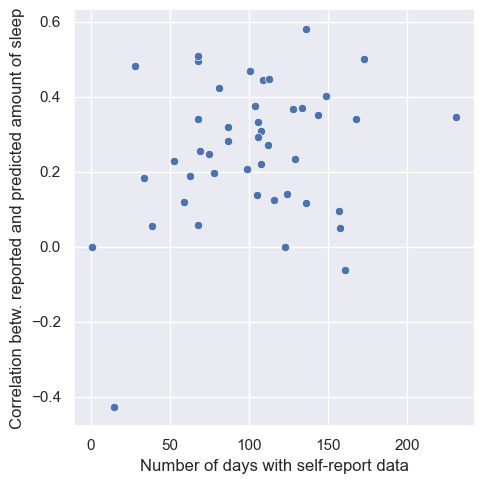

In [35]:
%matplotlib inline

sns.relplot(cor_reports, x='n', y='correlation') \
    .set(
        xlabel="Number of days with self-report data",
        ylabel="Correlation betw. reported and predicted amount of sleep"
    )

plt.savefig("images/cor_days_self-report.png", dpi=300)

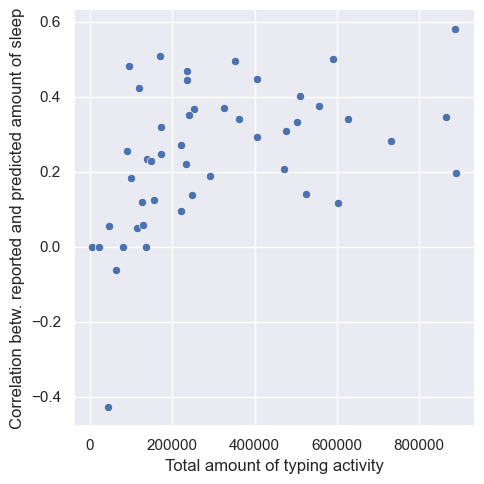

In [40]:
total_activities = [np.sum(np.array(res['Mactivity'])) for res in gsvd_results.values()]
cor_reports['activity'] = total_activities

sns.relplot(cor_reports, x='activity', y='correlation')\
    .set(
        xlabel="Total amount of typing activity",
        ylabel="Correlation betw. reported and predicted amount of sleep"
    )

plt.savefig("images/cor_activity.png", dpi=300)

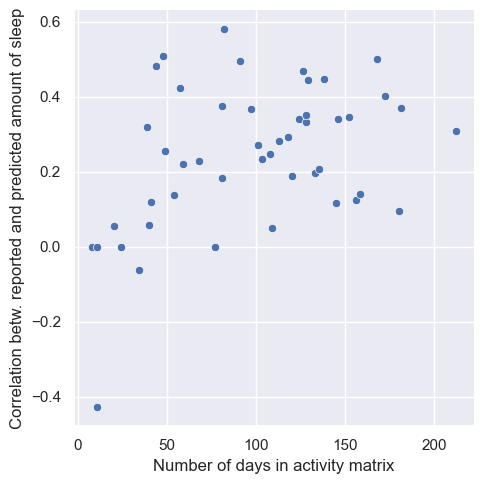

In [41]:
cor_reports['n_matrix'] = [len(res['Mactivity'].index) for res in gsvd_results.values()]

sns.relplot(cor_reports, x='n_matrix', y='correlation')\
    .set(
        xlabel="Number of days in activity matrix",
        ylabel="Correlation betw. reported and predicted amount of sleep"
    )

plt.savefig("images/cor_days_mat.png", dpi=300)

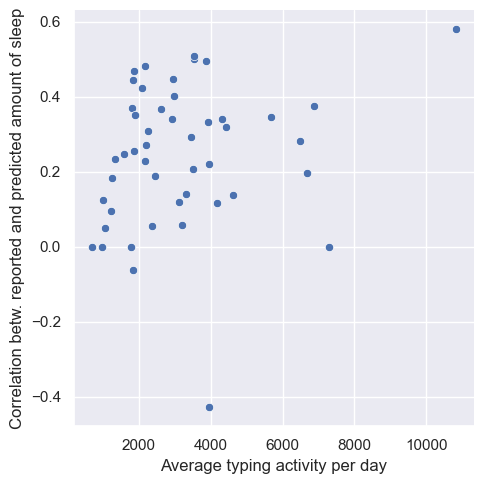

In [45]:
mats = [np.array(res['Mactivity']) for res in gsvd_results.values()]
cor_reports['activity_per_day'] = [np.sum(mat) / mat.shape[0] for mat in mats]

sns.relplot(cor_reports, x='activity_per_day', y='correlation')\
    .set(
        xlabel="Average typing activity per day",
        ylabel="Correlation betw. reported and predicted amount of sleep"
    )

plt.savefig("images/cor_activity_per_day.png", dpi=300)